## Generate Spectrograms

This script loads each recording and calculates spectrograms of the time series. Specifically, five consecutive thirty-second blocks of data are selected (from both channels) and the spectrograms are calculated on each 30 second block (for each channel).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pdb
import pandas as pd
import os
import glob
from scipy.signal import spectrogram
import pickle
import random
from librosa.feature import melspectrogram
from librosa import power_to_db
from librosa.display import specshow

import warnings
warnings.filterwarnings("error")

Define some constants

In [2]:
#all EEG data is 100Hz sampling rate
FS = 100

#length of spectrogram in seconds
SPEC_LEN = 30

#define the data directory
data_dir = 'data/'

#define Mel Spectrogram parameters
n_fft = 256
hop_length = 64
n_mels = 64

Define a function to get the most frequent label within a 30-second block, if there are multiple labels. The most frequent label will apply to the entire block.

In [3]:
def get_most_frequent_label(labels):
    unique_labels = np.unique(labels)
    label_counts = {}
    for unique_label in unique_labels:
        label_counts[unique_label] = sum(labels==unique_label)

    most_frequent_label = unique_labels[0]
    for key, value in label_counts.items():
        if value > label_counts[most_frequent_label]:
            most_frequent_label = key

    return most_frequent_label


Define a function to do the spectrogram calculations

In [4]:
def calculate_spectrograms(pkl_files, data_group):
    #store sets of 5 spectrograms and corresponding labels
    spectrogram_list = []
    labels_list = []
    do_plot = True

    for pkl_file in pkl_files:
        df = pd.read_pickle(pkl_file)
        spectrogram_list_tmp = []
        labels_list_tmp = []

        #load 5 thirty-second blocks of EEG data and corresponding labels
        #apply bandpass filters on each block, and then calculate the spectrogram
        #define the label of that window to the be the majority label if there are multiple labels
        ind = 0
        while(ind < len(df)):
            #grab 30 seconds of data
            df_tmp = df.iloc[ind:ind+FS*SPEC_LEN]
            ch1_tmp = df_tmp['EEG Fpz-Cz'].values
            ch2_tmp = df_tmp['EEG Pz-Oz'].values
            label_tmp = get_most_frequent_label(df_tmp['label'].values)

            #subtract mean, unit variance
            #sometimes there is garbage data that is flatlined constant, in which case the std is zero
            #catch the warning and throw away the whole 5 block group
            try:
                ch1_tmp = (ch1_tmp-np.mean(ch1_tmp))/np.std(ch1_tmp)
                ch2_tmp = (ch2_tmp-np.mean(ch2_tmp))/np.std(ch2_tmp)
            except Exception as e:
                spectrogram_list_tmp = []
                labels_list_tmp = []
                ind = ind + FS*SPEC_LEN
                continue
                
            #calculate mel spectrograms
            Sxx1 = melspectrogram(y=ch1_tmp, sr=FS, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
            Sxx1 = power_to_db(Sxx1, ref=np.max)

            Sxx2 = melspectrogram(y=ch2_tmp, sr=FS, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
            Sxx2 = power_to_db(Sxx2, ref=np.max)
    
            if do_plot and (ind==FS*SPEC_LEN*5):
                do_plot = False
                fig, ax = plt.subplots(figsize=(18,8))
                ax1 = plt.subplot(211)
                img = specshow(Sxx1, sr=FS, hop_length=hop_length, x_axis='time', y_axis='linear')
                fig.colorbar(img, ax=ax1, format="%+2.f dB")
                plt.ylabel('Frequency (Hz)\nCh1')
                ax2 = plt.subplot(212, sharex=ax1, sharey=ax1)
                img = specshow(Sxx2, sr=FS, hop_length=hop_length, x_axis='time', y_axis='linear')
                fig.colorbar(img, ax=ax2, format="%+2.f dB")
                plt.ylabel('Frequency (Hz)\nCh2')
                plt.xlabel('Time (Seconds)')
                plt.tight_layout()
                plt.savefig('spectrogram.png', dpi=150)
                plt.show()

            spectrogram_list_tmp.append((Sxx1, Sxx2))
            labels_list_tmp.append(label_tmp)
            ind = ind + FS*SPEC_LEN

            if len(spectrogram_list_tmp) == 5:
                #package this result, only if there are no -1 labels
                if -1 not in labels_list_tmp:
                    spectrogram_list.append(spectrogram_list_tmp)
                    labels_list.append(labels_list_tmp)

                spectrogram_list_tmp = []
                labels_list_tmp = []


    #save the results
    pickle.dump(spectrogram_list, open('X_%s_spec.pkl' % data_group, 'wb'))
    pickle.dump(labels_list, open('y_%s.pkl' % data_group, 'wb'))


Do the spectrogram calculations by train, test, and validation sets

In [5]:
# List of validation files 
# pkl_files_val = [
#     'data\\ST7181JR.pkl', 'data\\SC4352FV.pkl', 'data\\SC4261FM.pkl', 'data\\SC4751EC.pkl', 
#     'data\\SC4522EM.pkl', 'data\\SC4121EC.pkl', 'data\\SC4511EJ.pkl', 'data\\SC4171EU.pkl', 
#     'data\\ST7192JR.pkl', 'data\\ST7051JA.pkl', 'data\\SC4381FC.pkl', 'data\\SC4621EV.pkl', 
#     'data\\ST7211JJ.pkl', 'data\\SC4421EA.pkl', 'data\\SC4181EC.pkl', 'data\\SC4481FV.pkl', 
#     'data\\SC4252EU.pkl', 'data\\ST7212JJ.pkl', 'data\\SC4272FM.pkl'
# ]

# # List of test files 
# pkl_files_test = [
#     'data\\SC4442EV.pkl', 'data\\SC4412EM.pkl', 'data\\SC4321EC.pkl', 'data\\SC4452FW.pkl', 
#     'data\\ST7171JA.pkl', 'data\\SC4262FC.pkl', 'data\\SC4331FV.pkl', 'data\\SC4081EC.pkl', 
#     'data\\SC4741EA.pkl', 'data\\SC4091EC.pkl', 'data\\SC4801GC.pkl', 'data\\SC4382FW.pkl', 
#     'data\\SC4602EJ.pkl', 'data\\ST7202JO.pkl', 'data\\ST7152JA.pkl', 'data\\SC4232EV.pkl', 
#     'data\\SC4772GC.pkl', 'data\\SC4202EC.pkl', 'data\\SC4342FA.pkl'
# ]

# List of training files 
pkl_files_train = [
    'data\\SC4611EG.pkl', 'data\\SC4061EC.pkl', 'data\\SC4021EH.pkl', 'data\\SC4101EC.pkl', 
    'data\\ST7011JP.pkl', 'data\\SC4631EM.pkl', 'data\\SC4402EW.pkl', 'data\\SC4351FA.pkl', 
    'data\\SC4162EC.pkl', 'data\\SC4712EA.pkl', 'data\\SC4062EC.pkl', 'data\\SC4711EC.pkl', 
    'data\\SC4582GP.pkl', 'data\\SC4762EG.pkl', 'data\\SC4722EM.pkl', 'data\\ST7121JE.pkl', 
    'data\\SC4552FW.pkl', 'data\\SC4652EG.pkl', 'data\\ST7222JA.pkl', 'data\\SC4041EC.pkl', 
    'data\\SC4572FC.pkl', 'data\\SC4571FV.pkl', 'data\\ST7101JE.pkl', 'data\\SC4371FA.pkl', 
    'data\\SC4622EJ.pkl', 'data\\SC4221EJ.pkl', 'data\\SC4311EC.pkl', 'data\\SC4292GC.pkl', 
    'data\\SC4051EC.pkl', 'data\\SC4592GY.pkl', 'data\\ST7082JW.pkl', 'data\\SC4212EC.pkl', 
    'data\\ST7012JP.pkl', 'data\\SC4462FJ.pkl', 'data\\SC4601EC.pkl', 'data\\SC4811GG.pkl', 
    'data\\SC4542FW.pkl', 'data\\SC4661EJ.pkl', 'data\\SC4541FA.pkl', 'data\\SC4761EP.pkl', 
    'data\\SC4142EU.pkl', 'data\\ST7191JR.pkl', 'data\\SC4651EP.pkl', 'data\\SC4641EP.pkl', 
    'data\\SC4401EC.pkl', 'data\\SC4152EC.pkl', 'data\\SC4422EA.pkl', 'data\\ST7052JA.pkl', 
    'data\\ST7172JA.pkl', 'data\\SC4291GA.pkl', 'data\\ST7081JW.pkl', 'data\\SC4031EC.pkl', 
    'data\\ST7221JA.pkl', 'data\\SC4071EC.pkl', 'data\\SC4312EM.pkl', 'data\\SC4122EV.pkl', 
    'data\\ST7122JE.pkl', 'data\\ST7151JA.pkl', 'data\\SC4491GJ.pkl', 'data\\SC4242EA.pkl', 
    'data\\SC4112EC.pkl', 'data\\SC4011EH.pkl', 'data\\SC4222EC.pkl', 'data\\ST7072JA.pkl', 
    'data\\SC4771GC.pkl', 'data\\SC4282GC.pkl', 'data\\SC4581GM.pkl', 'data\\SC4362FC.pkl', 
    'data\\SC4172EC.pkl', 'data\\ST7042JO.pkl', 'data\\ST7162JM.pkl', 'data\\SC4591GY.pkl', 
    'data\\ST7201JO.pkl', 'data\\SC4322EC.pkl', 'data\\SC4431EM.pkl', 'data\\SC4281GC.pkl', 
    'data\\SC4502EM.pkl', 'data\\SC4672GV.pkl', 'data\\SC4482FJ.pkl', 'data\\SC4702EA.pkl', 
    'data\\SC4131EC.pkl', 'data\\SC4111EC.pkl', 'data\\SC4271FC.pkl', 
    'data\\SC4662EJ.pkl', 'data\\SC4201EC.pkl', 'data\\ST7111JE.pkl', 'data\\SC4701EC.pkl', 
    'data\\SC4141EU.pkl', 'data\\SC4822GC.pkl', 'data\\SC4561FJ.pkl', 'data\\SC4732EJ.pkl', 
    'data\\SC4551FC.pkl', 'data\\SC4671GJ.pkl', 'data\\SC4531EM.pkl', 'data\\SC4161EC.pkl', 
    'data\\SC4501EW.pkl', 'data\\SC4191EP.pkl', 'data\\SC4532EV.pkl', 'data\\SC4731EM.pkl', 
    'data\\SC4251EP.pkl', 'data\\SC4472FA.pkl', 'data\\SC4461FA.pkl', 'data\\ST7182JR.pkl', 
    'data\\ST7041JO.pkl', 'data\\SC4092EC.pkl', 'data\\SC4812GV.pkl', 'data\\SC4302EV.pkl', 
    'data\\ST7242JO.pkl', 'data\\SC4492GJ.pkl', 'data\\SC4632EA.pkl', 'data\\SC4642EP.pkl', 
    'data\\SC4052EC.pkl', 'data\\ST7091JE.pkl', 'data\\SC4411EJ.pkl', 'data\\ST7241JO.pkl', 
    'data\\SC4432EM.pkl', 'data\\SC4241EC.pkl', 'data\\ST7112JE.pkl', 'data\\SC4211EC.pkl', 
    'data\\SC4032EP.pkl', 'data\\SC4192EV.pkl', 'data\\SC4451FY.pkl', 'data\\SC4332FC.pkl', 
    'data\\SC4082EP.pkl', 'data\\ST7102JE.pkl', 'data\\ST7062JR.pkl', 'data\\SC4012EC.pkl', 
    'data\\SC4441EC.pkl', 'data\\ST7161JM.pkl', 'data\\SC4802GV.pkl', 'data\\SC4752EM.pkl', 
    'data\\SC4821GC.pkl', 'data\\SC4102EC.pkl', 'data\\SC4042EC.pkl', 'data\\SC4512EW.pkl', 
    'data\\SC4742EC.pkl', 'data\\SC4151EC.pkl', 'data\\SC4471FA.pkl', 'data\\SC4022EJ.pkl', 
    'data\\SC4072EH.pkl', 'data\\SC4301EC.pkl', 'data\\ST7061JR.pkl', 'data\\SC4372FC.pkl', 
    'data\\SC4562FJ.pkl', 'data\\SC4721EC.pkl', 'data\\SC4612EA.pkl', 'data\\SC4341FA.pkl', 
    'data\\SC4182EC.pkl', 'data\\SC4231EJ.pkl', 'data\\ST7022JM.pkl'
]


# calculate_spectrograms(pkl_files_val, 'val')
# calculate_spectrograms(pkl_files_test, 'test')
#calculate_spectrograms(pkl_files_train, 'train')



In [6]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


X_train = pickle.load(open('X_train_spec.pkl', 'rb'))
y_train = pickle.load(open('y_train.pkl', 'rb'))
X_val = pickle.load(open('X_val_spec.pkl', 'rb'))
y_val = pickle.load(open('y_val.pkl', 'rb'))
X_test = pickle.load(open('X_test_spec.pkl', 'rb'))
y_test = pickle.load(open('y_test.pkl', 'rb'))

# Check the structure of the loaded data
print(f"X_train: {type(X_train)}, length: {len(X_train)}, shape of first element: {np.array(X_train[0]).shape}")
print(f"y_train: {type(y_train)}, length: {len(y_train)}, labels: {np.unique(y_train)}")

print(f"X_val: {type(X_val)}, length: {len(X_val)}, shape of first element: {np.array(X_val[0]).shape}")
print(f"y_val: {type(y_val)}, length: {len(y_val)}, labels: {np.unique(y_val)}")

print(f"X_test: {type(X_test)}, length: {len(X_test)}, shape of first element: {np.array(X_test[0]).shape}")
print(f"y_test: {type(y_test)}, length: {len(y_test)}, labels: {np.unique(y_test)}")


Exception ignored in: <_io.FileIO name='X_train_spec.pkl' mode='rb' closefd=True>
Traceback (most recent call last):
  File "C:\Users\Kaustubh\AppData\Local\Temp\ipykernel_73532\1953900698.py", line 7, in <module>
Exception ignored in: <_io.FileIO name='y_train.pkl' mode='rb' closefd=True>
Traceback (most recent call last):
  File "C:\Users\Kaustubh\AppData\Local\Temp\ipykernel_73532\1953900698.py", line 8, in <module>
Exception ignored in: <_io.FileIO name='X_val_spec.pkl' mode='rb' closefd=True>
Traceback (most recent call last):
  File "C:\Users\Kaustubh\AppData\Local\Temp\ipykernel_73532\1953900698.py", line 9, in <module>
Exception ignored in: <_io.FileIO name='y_val.pkl' mode='rb' closefd=True>
Traceback (most recent call last):
  File "C:\Users\Kaustubh\AppData\Local\Temp\ipykernel_73532\1953900698.py", line 10, in <module>
Exception ignored in: <_io.FileIO name='X_test_spec.pkl' mode='rb' closefd=True>
Traceback (most recent call last):
  File "C:\Users\Kaustubh\AppData\Local\T

X_train: <class 'list'>, length: 71139, shape of first element: (5, 2, 64, 47)
y_train: <class 'list'>, length: 71139, labels: [0 1 2 3 4 5]
X_val: <class 'list'>, length: 8634, shape of first element: (5, 2, 64, 47)
y_val: <class 'list'>, length: 8634, labels: [0 1 2 3 4 5]
X_test: <class 'list'>, length: 9228, shape of first element: (5, 2, 64, 47)
y_test: <class 'list'>, length: 9228, labels: [0 1 2 3 4 5]


### Visualization

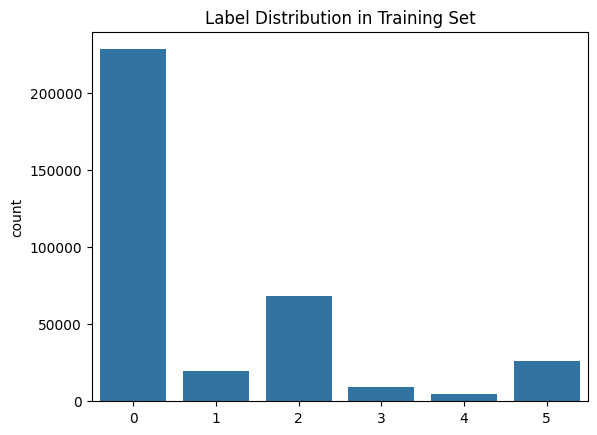

In [7]:
import itertools

# Flatten the list of labels
flat_y_train = list(itertools.chain.from_iterable(y_train))
flat_y_val = list(itertools.chain.from_iterable(y_val))
flat_y_test = list(itertools.chain.from_iterable(y_test))

# Plot the label distribution for the training set
sns.countplot(x=flat_y_train)
plt.title('Label Distribution in Training Set')
plt.show()


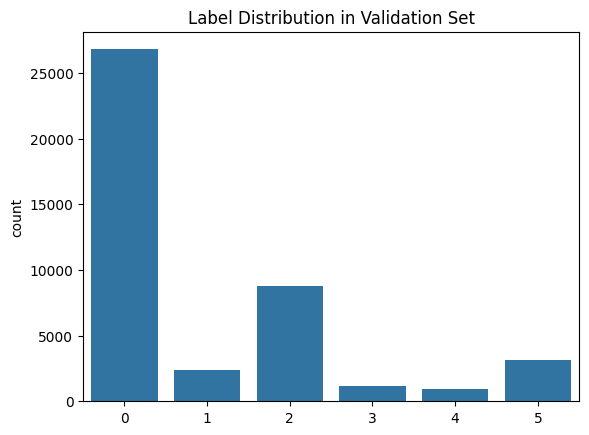

In [8]:
# Plot the label distribution for the validation set
sns.countplot(x=flat_y_val)
plt.title('Label Distribution in Validation Set')
plt.show()

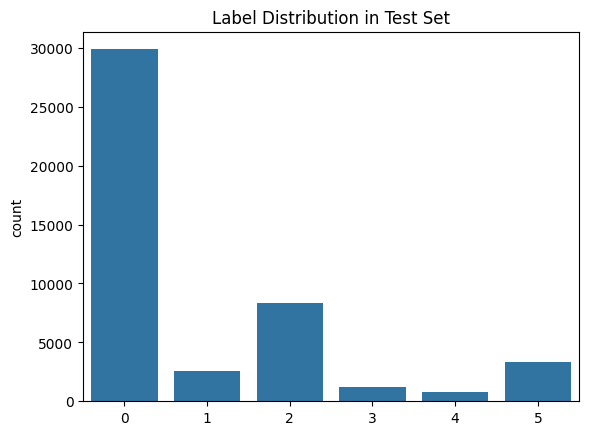

In [9]:
sns.countplot(x=flat_y_test)
plt.title('Label Distribution in Test Set')
plt.show()

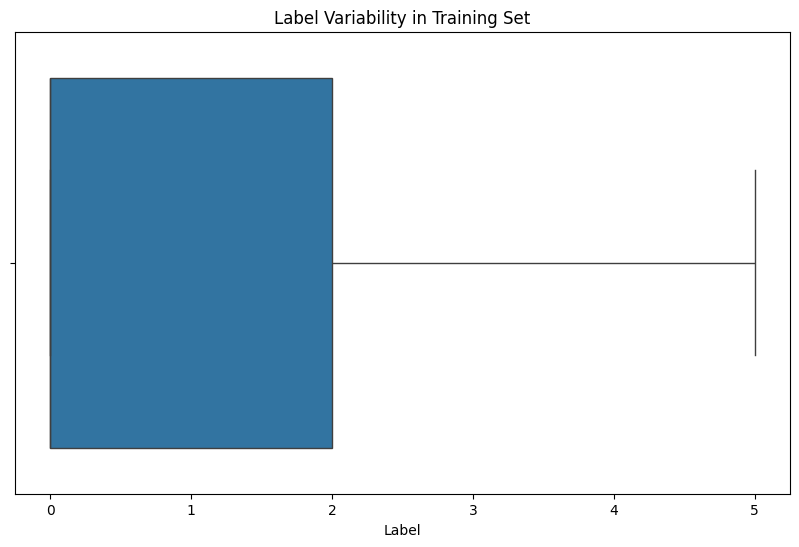

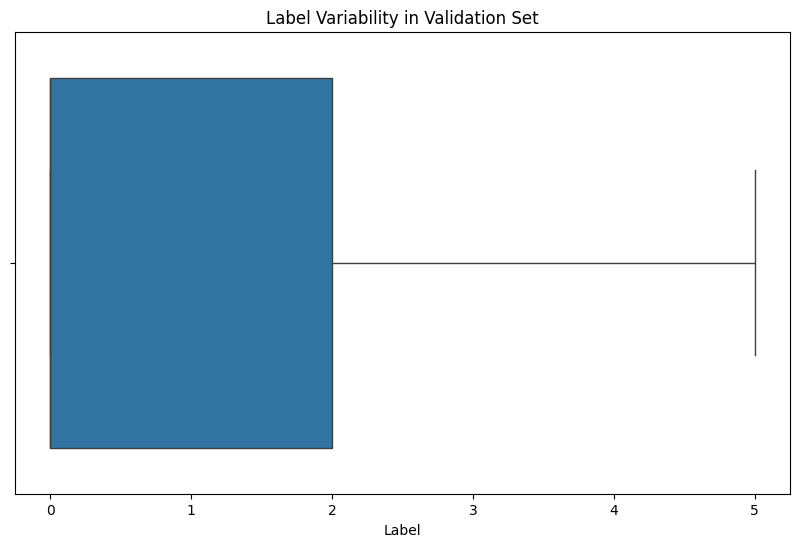

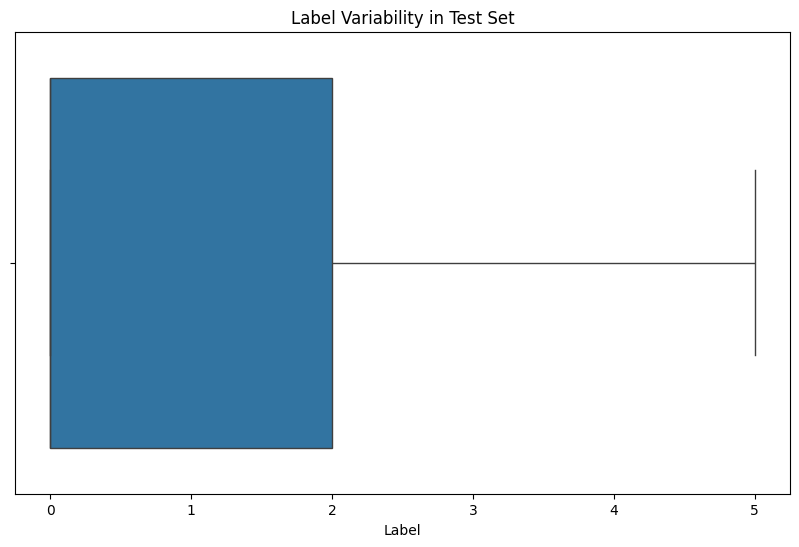

In [13]:
import seaborn as sns

def plot_label_boxplot(y, dataset_name):
    # Flatten the list of labels if necessary
    flattened_labels = list(itertools.chain.from_iterable(y))
    
    # Create a DataFrame for the boxplot
    df = pd.DataFrame({'Label': flattened_labels})
    
    # Plot box plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df['Label'])
    plt.title(f'Label Variability in {dataset_name}')
    plt.xlabel('Label')
    plt.show()

plot_label_boxplot(y_train, 'Training Set')
plot_label_boxplot(y_val, 'Validation Set')
plot_label_boxplot(y_test, 'Test Set')


In [10]:
def summarize_spectrograms(X, dataset_name):
    mean_ch1, mean_ch2 = [], []
    std_ch1, std_ch2 = [], []

    # Flatten the list of spectrograms
    flat_X = [item for sublist in X for item in sublist]

    for Sxx1, Sxx2 in flat_X:
        mean_ch1.append(np.mean(Sxx1))
        mean_ch2.append(np.mean(Sxx2))
        std_ch1.append(np.std(Sxx1))
        std_ch2.append(np.std(Sxx2))

    print(f'{dataset_name} - Ch1 Mean: {np.mean(mean_ch1)}, Std: {np.mean(std_ch1)}')
    print(f'{dataset_name} - Ch2 Mean: {np.mean(mean_ch2)}, Std: {np.mean(std_ch2)}')

# Assuming X_train, X_val, and X_test have been loaded from their respective pickle files
summarize_spectrograms(X_train, 'Training Set')
summarize_spectrograms(X_val, 'Validation Set')
summarize_spectrograms(X_test, 'Test Set')


Training Set - Ch1 Mean: -31.49228712292264, Std: 7.46906694045079
Training Set - Ch2 Mean: -26.79359812692958, Std: 6.770500387654544
Validation Set - Ch1 Mean: -32.404336603290815, Std: 7.792114118100877
Validation Set - Ch2 Mean: -27.121561100193464, Std: 6.964382429576787
Test Set - Ch1 Mean: -30.878662517428864, Std: 7.2660263498347595
Test Set - Ch2 Mean: -27.044295262466996, Std: 6.826631977435107


### Checking for Null values if any

In [11]:
flat_X = [item for sublist in X_train for item in sublist]
spectrogram_df = pd.DataFrame(flat_X)
labels_df_train = pd.DataFrame(flat_y_train)
labels_df_val = pd.DataFrame(flat_y_val)
labels_df_test = pd.DataFrame(flat_y_test)

# Check for null values in spectrogram data
print("Null values in spectrogram data:")
print(spectrogram_df.isnull().sum().sum())  # Total null values

# Check for null values in labels
print("\nNull values in training labels:")
print(labels_df_train.isnull().sum().sum())
print("\nNull values in validation labels:")
print(labels_df_val.isnull().sum().sum())
print("\nNull values in test labels:")
print(labels_df_test.isnull().sum().sum())

Null values in spectrogram data:
0

Null values in training labels:
0

Null values in validation labels:
0

Null values in test labels:
0


### Correlation Matrix

In [12]:
 #import numpy as np
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# def plot_correlation_matrix(X, dataset_name):
#     # Flatten each spectrogram from 2D to 1D
#     flattened_spectrograms = [spectrogram.flatten() for sublist in X for spectrogram in sublist]
    
#     # Create a DataFrame from the flattened spectrograms
#     df = pd.DataFrame(flattened_spectrograms)
    
#     # Compute the correlation matrix
#     correlation_matrix = df.corr()
    
#     # Plot the correlation matrix
#     plt.figure(figsize=(12, 10))
#     sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
#     plt.title(f'{dataset_name} - Correlation Matrix of Spectrogram Features')
#     plt.show()

# # plot_correlation_matrix(flat_X, 'Training Set')
# plot_correlation_matrix(flat_X_val, 'Validation Set')
# plot_correlation_matrix(flat_X_test, 'Test Set')

In [17]:
def print_pairwise_correlation(X, dataset_name, num_samples=3):
    # Ensure we do not sample more than available
    num_samples = min(num_samples, len(X))
    
    # Select exactly `num_samples` random indices
    subset_indices = np.random.choice(len(X), num_samples, replace=False)
    
    flat_spectrograms = []
    for i in subset_indices:
        item = X[i]  # Access the item
        if isinstance(item, tuple) and len(item) == 2:
            Sxx1, Sxx2 = item  # Unpack the tuple
            if isinstance(Sxx1, np.ndarray) and isinstance(Sxx2, np.ndarray):
                flat_spectrograms.extend(Sxx1.flatten())
                flat_spectrograms.extend(Sxx2.flatten())
            else:
                print(f"Unexpected type in item {i}: {type(Sxx1)}, {type(Sxx2)}")
        else:
            print(f"Unexpected item structure at index {i}: {item}")
    
    # Create a DataFrame from the flattened values
    df = pd.DataFrame([flat_spectrograms])
    
    # Calculate correlation matrix
    correlation_matrix = df.corr()
    
    print(f'{dataset_name} - Pairwise Correlation Matrix (sampled):')
    print(correlation_matrix)

print_pairwise_correlation(X_train, 'Training Set', num_samples=3)
print_pairwise_correlation(X_val, 'Validation Set', num_samples=3)
print_pairwise_correlation(X_test, 'Test Set', num_samples=3)


Unexpected item structure at index 8464: [(array([[-18.70559692, -14.29530054, -10.60285322, ...,  -8.48191081,
        -12.07382262, -15.79678559],
       [-22.96742494, -13.44265586, -15.0339944 , ...,  -7.2346985 ,
        -21.39789572, -23.90068996],
       [-22.60216001, -15.15795049, -17.94201562, ...,  -8.14121434,
        -22.32398767, -28.23881126],
       ...,
       [-39.21390823, -39.62125001, -40.04808841, ..., -41.1196998 ,
        -37.47119474, -39.0434674 ],
       [-36.26889339, -35.68158914, -40.10195488, ..., -39.46747123,
        -40.30720669, -37.21366783],
       [-35.94146279, -34.46714594, -35.66807056, ..., -41.24825619,
        -45.52820905, -46.249708  ]]), array([[ -8.10580272,  -3.87580531,  -1.68076294, ...,  -8.59501706,
         -9.37611974,  -8.08073854],
       [-13.66454633,  -9.73923975, -11.9984409 , ..., -11.44492573,
        -11.08265463, -11.13055982],
       [-20.97907986, -13.79578199, -12.04324178, ..., -19.57434865,
        -15.03616075, -10.